In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/MyDrive/Structural_data/DCL

bu_feat.csv.gz	test.csv.gz  train.csv.gz


In [4]:
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [5]:
train_df = pd.read_csv('/content/gdrive/MyDrive/Structural_data/DCL/train.csv.gz')
train_df['day_id'] = pd.to_datetime(train_df['day_id'], format='%Y-%m-%d')
train_df = train_df.sort_values(by='day_id', ascending=True).reset_index(drop=True)

test_df = pd.read_csv('/content/gdrive/MyDrive/Structural_data/DCL/test.csv.gz')
test_df['day_id'] = pd.to_datetime(test_df['day_id'], format='%Y-%m-%d')
test_df = test_df.sort_values(by='day_id', ascending=True).reset_index(drop=True)

bu_df = pd.read_csv('/content/gdrive/MyDrive/Structural_data/DCL/bu_feat.csv.gz')

In [6]:
train_df.head()

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2012-12-29,54,73,53.337413
1,2012-12-29,255,73,0.000000
2,2012-12-29,812,73,43.619478
3,2012-12-29,24,73,5.237134
4,2012-12-29,201,127,825.383999


In [7]:
print(train_df.describe())

       but_num_business_unit  dpt_num_department        turnover
count          277719.000000       277719.000000   277719.000000
mean              294.199464          101.288832      561.818472
std               291.664511           21.667318     2113.229765
min                 1.000000           73.000000      -69.791165
25%                81.000000           88.000000       11.785140
50%               204.000000           88.000000      232.724186
75%               427.000000          127.000000      676.655825
max              1887.000000          127.000000  1000000.000000


In [8]:
test_df.head()

,day_id,but_num_business_unit,dpt_num_department
0,2017-10-07,1126,88
1,2017-10-07,259,88
2,2017-10-07,158,127
3,2017-10-07,496,117
4,2017-10-07,214,127


In [9]:
bu_df.head()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,1609,80100,50.096306,1.867220,69,4
1,1995,95700,48.991087,2.520903,3,6
2,1800,73210,45.552933,6.644736,51,4
3,238,47550,44.175370,0.638869,134,10
4,201,13546,43.508418,5.406423,71,10


# **Preliminary questions & data**

In [10]:
# Which department made the highest turnover in 2016?
df_2016 = train_df[train_df['day_id'].dt.year == 2016]
dptMaxTurnover = df_2016.groupby('dpt_num_department')['turnover'].sum().idxmax()
print(f"department made the highest turnover is: {dptMaxTurnover}")

department made the highest turnover is: 127


In [11]:
# What are the top 5 week numbers (1 to 53) for department 88 in 2015 in terms of turnover over all stores?
df_2015_dpt88 = train_df[(train_df['day_id'].dt.year == 2015) & (train_df['dpt_num_department'] == 88)]
df_2015_dpt88['week_of_the_year'] = df_2015_dpt88['day_id'].dt.isocalendar().week
top_5_week = df_2015_dpt88.groupby('week_of_the_year')['turnover'].sum().sort_values(ascending=False).index[:5]
print(f"the top 5 week numbers (1 to 53) for department 88 in 2015 in terms of turnover: {list(top_5_week)}")

the top 5 week numbers (1 to 53) for department 88 in 2015 in terms of turnover: [27, 37, 36, 38, 28]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# What was the top performer store in 2014?

df_2014 = train_df[train_df['day_id'].dt.year == 2014]
top_perfomer_store = df_2014.groupby('but_num_business_unit')['turnover'].sum().sort_values(ascending=False).index[0]
print('top performer store in 2014 is: {}'.format(top_perfomer_store))

top performer store in 2014 is: 121


In [13]:
def plot_by_dpt(dpt):
    df_dpt = train_df[train_df['dpt_num_department'] == dpt].groupby('day_id')['turnover'].sum()
    plt.figure(figsize=(30,5))
    plt.subplot(131)
    df_dpt.hist()
    plt.subplot(132)
    df_dpt.plot(kind='kde', title='Kernel Density Estimation')
    plt.subplot(133)
    df_dpt.plot(title='Line plot by year')
    plt.show()

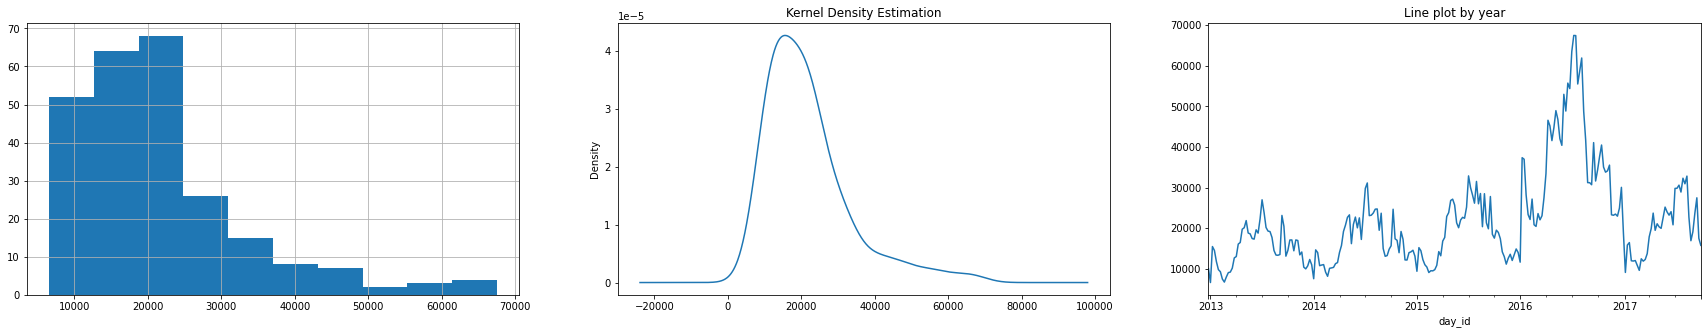

In [14]:
# Based on sales can you guess what kind of sport represents departement 73?
plot_by_dpt(73)

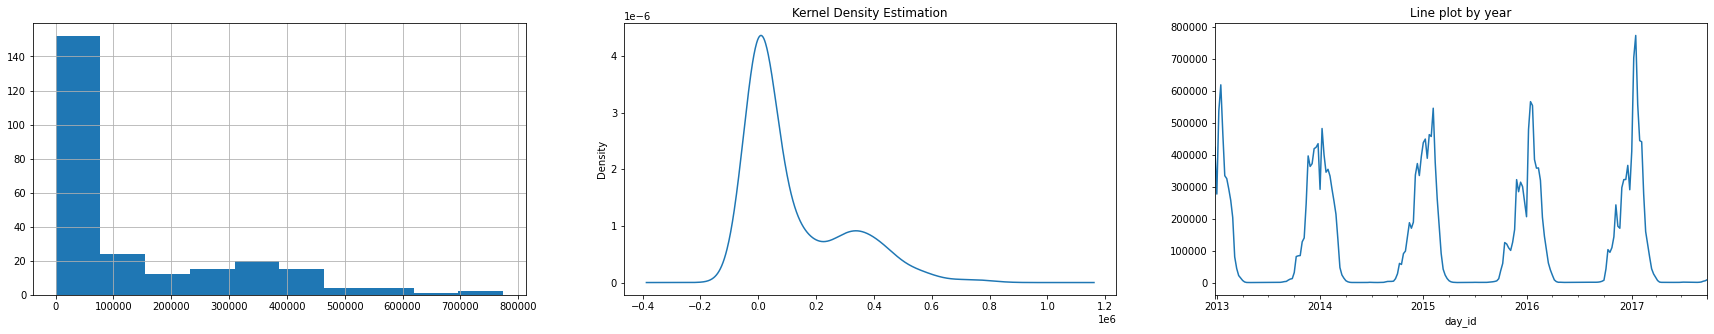

In [15]:
# Based on sales can you guess what kind of sport represents departement 117?
plot_by_dpt(117)

- for department 73, the turnover is smaller and the difference in revenue between months in 1 year is not too large, so in my opinion football can represents this department

- for department 117, the turnover is huge and the difference in revenue between months in 1 year is large, so in my opinion skiing can represents this department where people play spend more in some winter months

# **2. Forecast model**

The problem is forecastin sales with time series (weekly) data. For each unit store of a department, we will build model to train, test and then benchmarking the scores based on 3 algorithms: Random Forest Regression, XGBoost and Autoregressive integrated moving average (ARIMA). Below I take unit store 95 of department 88 for example

In [16]:
import datetime

In [17]:
# 1. Determining if data is stationary
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='blue', label='Total Sales')
    
    second = data.groupby(data[x_col].dt.year)[y_col].mean().reset_index()
    second[x_col] = pd.to_datetime(second[x_col], format='%Y')
    sns.lineplot((second[x_col] + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "day_id", ylabel = "Turnover", title = title)
    
    sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


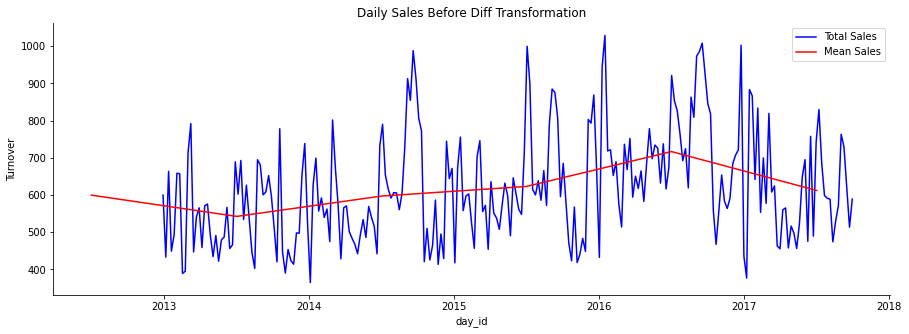

In [19]:
df_unit95_dpt88 = train_df[(train_df['but_num_business_unit'] == 95) & (train_df['dpt_num_department'] == 88)].reset_index(drop=True)
time_plot(df_unit95_dpt88, 'day_id', 'turnover', 'Daily Sales Before Diff Transformation')

In [20]:
# 2. The data is not stationary. To make it stationary, we need to calculate the difference between turnovers in each week

df_unit95_dpt88_diff = df_unit95_dpt88[['day_id', 'turnover']].copy()
df_unit95_dpt88_diff['prev_turnover'] = df_unit95_dpt88_diff['turnover'].shift(1)
df_unit95_dpt88_diff = df_unit95_dpt88_diff.dropna()
df_unit95_dpt88_diff['diff'] = (df_unit95_dpt88_diff['turnover'] - df_unit95_dpt88_diff['prev_turnover'])
df_unit95_dpt88_diff.head(10)

,day_id,turnover,prev_turnover,diff
1,2013-01-05,433.119874,599.697597,-166.577722
2,2013-01-12,663.697407,433.119874,230.577533
3,2013-01-19,449.153513,663.697407,-214.543895
4,2013-01-26,493.235371,449.153513,44.081859
5,2013-02-02,658.562919,493.235371,165.327547
6,2013-02-09,657.150672,658.562919,-1.412247
7,2013-02-16,389.138436,657.150672,-268.012236
8,2013-02-23,394.957439,389.138436,5.819002
9,2013-03-02,713.364695,394.957439,318.407256
10,2013-03-09,791.781878,713.364695,78.417183


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


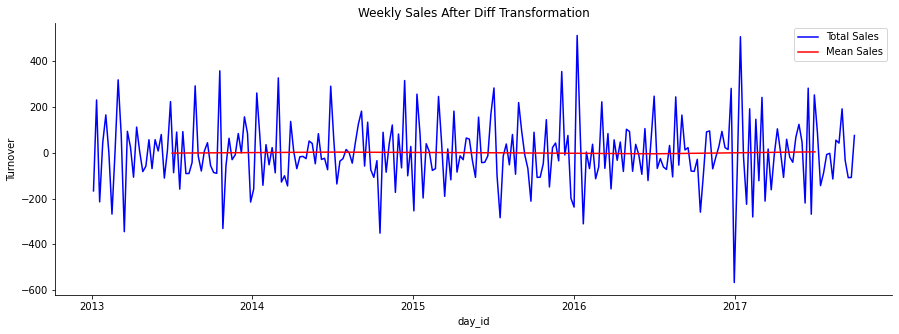

In [21]:
time_plot(df_unit95_dpt88_diff, 'day_id', 'diff', 'Weekly Sales After Diff Transformation')

In [22]:
import statsmodels.tsa.api as smt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(248, 1)
                  diff
day_id                
2013-01-05 -166.577722
2013-01-12  230.577533
2013-01-19 -214.543895
2013-01-26   44.081859
2013-02-02  165.327547


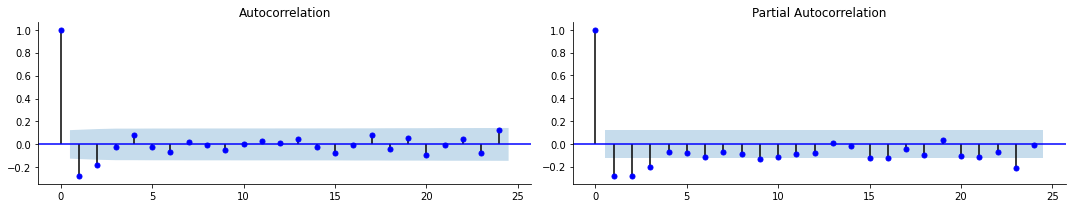

In [23]:
# 3. Observing and choosing lag

def plots(data, lags=None):
    
    dt_data = data.set_index('day_id')#.drop('turnover', axis=1)
    dt_data.dropna(axis=0)
    
    plt.figure(figsize=(15,3))
    layout = (1, 2)
    acf  = plt.subplot2grid(layout, (0, 0))
    pacf = plt.subplot2grid(layout, (0, 1))
    
    print(dt_data.shape)
    print(dt_data.head())
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='blue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='blue')
    sns.despine()
    plt.tight_layout()

plots(df_unit95_dpt88_diff[['day_id', 'diff']], lags=24)

Based on the above, I will choose lag of 2, in other words make a look-back period to be 2 months, because of the significance at 2 of both acf and pacf figure

In [24]:
# 4. Generate data with lag=2, note that this is only for store id 95 department 88
def generate_supervised(data):
    supervised_df = data.copy()
    
    # create column for each lag
    for i in range(1,3):
        col = 'lag_' + str(i)
        supervised_df[col] = supervised_df['diff'].shift(i)
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    return supervised_df

stationary_df = df_unit95_dpt88_diff[['turnover', 'diff']]
model_df = generate_supervised(stationary_df)

In [25]:
model_df.head()

,turnover,diff,lag_1,lag_2
0,449.153513,-214.543895,230.577533,-166.577722
1,493.235371,44.081859,-214.543895,230.577533
2,658.562919,165.327547,44.081859,-214.543895
3,657.150672,-1.412247,165.327547,44.081859
4,389.138436,-268.012236,-1.412247,165.327547


In [26]:
# 5. Train test split. I will separate the data so that the last 12 months are part of the test set and the rest is used to train
def trainTestSplit(data):
    data = data.drop(['turnover'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    return train, test

train, test = trainTestSplit(model_df)

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [29]:
# 6. Helper functions

"""
Scale the data so that all of our variables fall within the range of -1 to 1
Params:
    train_set: shape (None, 3)
    test_set: shape (None,3)
"""
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

"""
After running our models, we will use this helper function to reverse the scaling in scale_data
Params:
    y_pred: shape (12,)
    x_test: shape (12,2)
    scaler_obj: a MinMaxScaler object
Return:
    an array shape (12,3)
"""

def undo_scaling(y_pred, x_test, scaler_obj):  
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

"""
generate a data frame that includes the actual sales captured in our test set and the predicted results.
Params:
    unscaled_predictions: shape (12, 3)
    original_df: dataframe of a store in a department
Return:
    a dataframe shape (12, 2) with 2 columns pred_value and date
"""
def predict_df(unscaled_predictions, original_df):
    result_list = []
    sales_dates = list(original_df[-13:]['day_id'])
    act_sales = list(original_df[-13:]['turnover'])
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = unscaled_predictions[index][0] + act_sales[index]
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

"""
Function help to score the models
Params:
    unscaled_df: shape (12, 2)
    original_df: shape (294, 4)
    model_name: a string name of model
"""
def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.turnover[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.turnover[-12:], unscaled_df.pred_value[-12:])
    print(f"for model {model_name}:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

*Q: Which metric would you use to evaluate your predictions and why ?*

Like the majority of regresion problem, we use root mean squared error (RMSE) and mean absolute error (MAE). We choose both of them because MAE informs us how close our predictions are to the ground truth on average and with RMSE, when we square the errors, the larger errors have a bigger impact on the entire error, but smaller errors have less impact.

**Random Forest Regressor**

In [30]:
X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

train_set shape: (234, 3)
train_set_scaled shape: (234, 3)
test_set_scaled shape: (234, 1)


In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(234, 2)
(234,)
(12, 2)
(12,)


In [33]:
mod = RandomForestRegressor(n_estimators=200, max_depth=30)
mod.fit(X_train, y_train)
predictions = mod.predict(X_test)

In [34]:
unscaled = undo_scaling(predictions, X_test, scaler_object)

In [35]:
unscaled_df = predict_df(unscaled, df_unit95_dpt88)

In [36]:
get_scores(unscaled_df, df_unit95_dpt88, 'RandomForestRegressor')

for model RandomForestRegressor:
RMSE: 104.00700897365945
MAE: 81.11505021965708


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


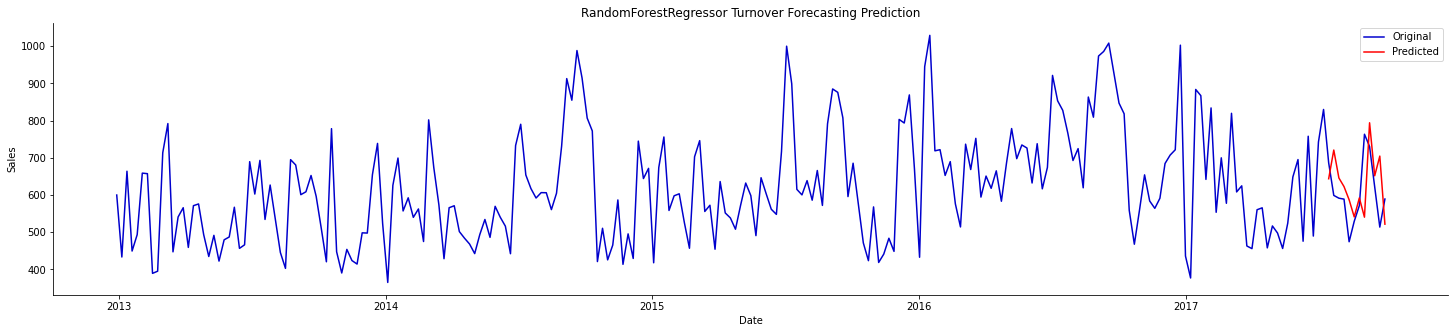

In [37]:
def plot_results(results_df, original_df, model_name):
    fig, ax = plt.subplots(figsize=(25,5))
    sns.lineplot(original_df['day_id'], original_df['turnover'], ax=ax, 
                  label='Original', color='mediumblue') #data=df_unit95_dpt88
    sns.lineplot(results_df['date'], results_df['pred_value'], ax=ax, 
                  label='Predicted', color='Red') #data=unscaled_df

    ax.set(xlabel = "Date",
            ylabel = "Sales",
            title = f"{model_name} Turnover Forecasting Prediction")

    ax.legend()

    sns.despine()

plot_results(unscaled_df, df_unit95_dpt88, 'RandomForestRegressor')

**XGBoost**

for model XGBRegressor:
RMSE: 121.80886190411468
MAE: 103.91481127798089


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


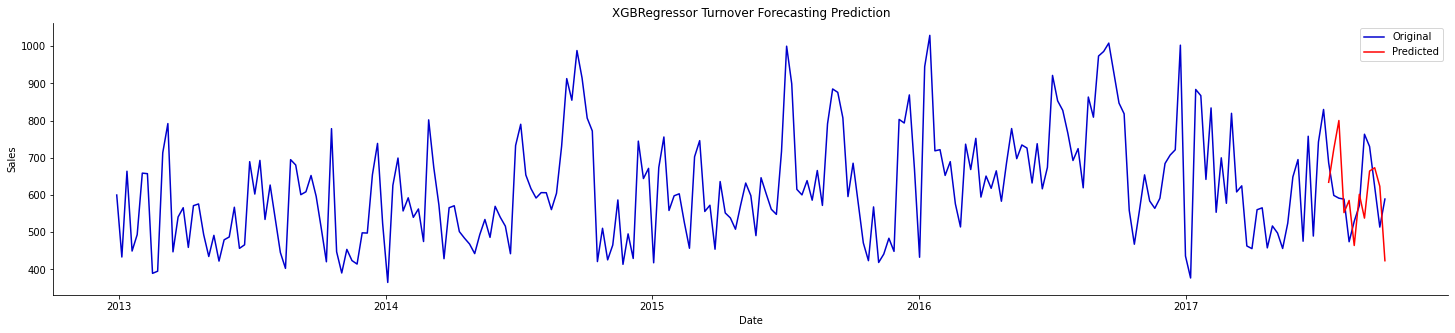

In [38]:
mod = XGBRegressor( n_estimators=200, 
                    learning_rate=0.2, 
                    objective='reg:squarederror')

mod.fit(X_train, y_train)
predictions = mod.predict(X_test)
unscaled = undo_scaling(predictions, X_test, scaler_object)
unscaled_df = predict_df(unscaled, df_unit95_dpt88)
get_scores(unscaled_df, df_unit95_dpt88, 'XGBRegressor')
plot_results(unscaled_df, df_unit95_dpt88, 'XGBRegressor')

**ARIMA model**

In [39]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

In [40]:
# helper functions

def predict_df_Arima(predictions, original_df, nb_test):
    result_list = []
    sales_dates = list(original_df[-(nb_test+1):]['day_id'])
    actual_sales = list(original_df[-(nb_test+1):]['turnover'])
    
    for index in range(0,len(predictions)):
        result_dict = {}
        result_dict['pred_value'] = predictions[index] + actual_sales[index]
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    return df_result

def get_scores_Arima(data, nb_test):
    
    rmse = np.sqrt(mean_squared_error(data['diff'][-nb_test:], data['forecast'][-nb_test:]))
    mae = mean_absolute_error(data['diff'][-nb_test:], data['forecast'][-nb_test:])
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

(248, 1)
                  diff
day_id                
2013-01-05 -166.577722
2013-01-12  230.577533
2013-01-19 -214.543895
2013-01-26   44.081859
2013-02-02  165.327547


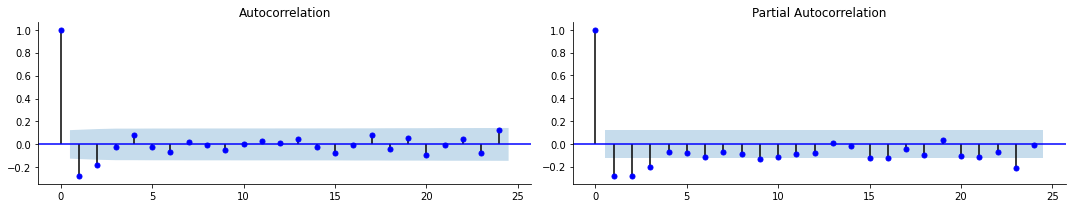

In [41]:
plots(df_unit95_dpt88_diff[['day_id', 'diff']], lags=24)


To build a ARIMA model, we will determine the triplet (p,d,q) parameter:
- p is order of AR term. By looking at PACF plot, we can choose p lags of 3 since it stands out of average.
- d is differencing to make data stationary, d is 0 since we have already done it.
- p is order of MA term. From ACF plot, we select 2 since it is a litte bit above the significant line

In [42]:
# train test split
train_Arima = df_unit95_dpt88_diff[0:-12]
test_Arima = df_unit95_dpt88_diff[-12:]

In [43]:
sar = sm.tsa.statespace.SARIMAX(train_Arima['diff'], order=(3,0,2)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [44]:
# Create a prediction array of last 12 weeks in train set and put them as new column in original dataframe

df_unit95_dpt88_copy_diff = df_unit95_dpt88_diff.copy()
start, end, dynamic = train_Arima.shape[0], df_unit95_dpt88_diff.shape[0], True
df_unit95_dpt88_copy_diff['forecast'] = 0
df_unit95_dpt88_copy_diff['forecast'][-12:] = list(sar.predict(start=start+1, end=end, dynamic=dynamic))
pred_df = df_unit95_dpt88_copy_diff.forecast[start+dynamic:end]

get_scores_Arima(df_unit95_dpt88_copy_diff, 12)

RMSE: 93.37113200206025
MAE: 77.73835441893932


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


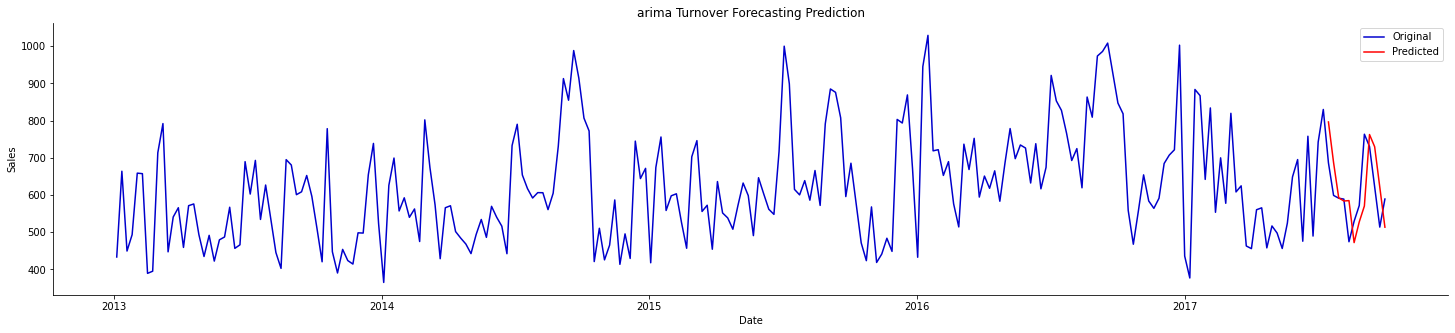

In [46]:
# plot the regression result in comparison with grouth truth turnover

predictions = df_unit95_dpt88_copy_diff.forecast[start:end]
prediction_df = predict_df_Arima(predictions.values, df_unit95_dpt88_copy_diff, 12)
plot_results(prediction_df, df_unit95_dpt88_copy_diff, 'arima')

We can see that overall the ARIMA model had the better performance than Random Forest and XGBoost. We will use it to forecast the sale in test set

In [47]:
# train ARIMA model on whole training set

sar = sm.tsa.statespace.SARIMAX(df_unit95_dpt88_diff['diff'], order=(3,0,2)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [48]:
# extract the data of store unit 95 department 88 from test set into a dataframe
df_test_95_88 = test_df[(test_df['but_num_business_unit'] == 95) & (test_df['dpt_num_department'] == 88)].reset_index(drop=True)

In [49]:
# make predictions for next 8 steps with ARIMA model
start, end = df_unit95_dpt88_diff.shape[0]+1, df_unit95_dpt88_diff.shape[0]+8
predictions = sar.predict(start=start, end=end)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [52]:
# Make a new column called "pred_turnover" and assign predictions values to it

df_test_95_88['pred_turnover'] = 0
lastActualTurnover = df_unit95_dpt88_diff.iloc[-1]['turnover']
lastPredTurnover = lastActualTurnover
predictionsArray = predictions.values

for index in range(0,len(predictions)):
    result_dict = {}
    df_test_95_88.loc[index, 'pred_turnover'] = predictionsArray[index] + lastPredTurnover
    lastPredTurnover = df_test_95_88.loc[index, 'pred_turnover']
        
print(df_test_95_88)

      day_id  but_num_business_unit  dpt_num_department  pred_turnover
0 2017-10-07                     95                  88     589.316773
1 2017-10-14                     95                  88     592.018300
2 2017-10-21                     95                  88     596.572694
3 2017-10-28                     95                  88     599.236753
4 2017-11-04                     95                  88     600.616792
5 2017-11-11                     95                  88     601.572145
6 2017-11-18                     95                  88     602.252446
7 2017-11-25                     95                  88     602.694436


# **3. ML pipeline**

In [54]:
# a. Reads the raw data
def read_raw_data(path, dateColumnName='day_id'):
    train_df = pd.read_csv(path)
    train_df[dateColumnName] = pd.to_datetime(train_df[dateColumnName], format='%Y-%m-%d')
    train_df = train_df.sort_values(by=dateColumnName, ascending=True).reset_index(drop=True)
    return train_df

In [55]:
# b. transforms the data in the right format for the model
def transformData(storeID, dpt, original_df, differencing_lag=1):
    df_store = original_df[(original_df['but_num_business_unit'] == storeID) & (original_df['dpt_num_department'] == dpt)].reset_index(drop=True)
    df_store_diff = df_store[['day_id', 'turnover']].copy()
    df_store_diff['prev_turnover'] = df_store_diff['turnover'].shift(differencing_lag)
    df_store_diff = df_store_diff.dropna()
    df_store_diff['diff'] = df_store_diff['turnover'] - df_store_diff['prev_turnover']
    return df_store_diff

In [56]:
# c. Trains the model
def run_model(arima_order, nb_forTest, originalDF):
    train_series = originalDF['diff'][0:-nb_forTest]
    sar = sm.tsa.statespace.SARIMAX(train_series, order=arima_order).fit()
    return sar, train_series

In [62]:
# d. Exposes the results
def test_model(nb_forTest, original_df, sar):
    df_diff_copy = original_df.copy()
    start_step = original_df.shape[0] - nb_forTest + 1
    end_step = original_df.shape[0]
    df_diff_copy['forecast'] = 0
    df_diff_copy['forecast'][-nb_forTest:] = list(sar.predict(start=start_step, end=end_step, dynamic=True))
    get_scores_Arima(df_diff_copy, nb_forTest)
    return df_diff_copy

In [58]:
# e. Monitors the model performance
def monitor_performance(diffDF, nb_forTest):
    start = diffDF.shape[0] - nb_forTest + 1
    end = diffDF.shape[0]
    predictions = diffDF.forecast[start:end]
    prediction_df = predict_df_Arima(predictions.values, diffDF, nb_forTest)
    plot_results(prediction_df, diffDF, 'arima')

In [59]:
train_df = read_raw_data('/content/gdrive/MyDrive/Structural_data/DCL/train.csv.gz')

In [60]:
df_store_diff_54_73 = transformData(54, 73, train_df)

In [61]:
sarModel, train_series = run_model((3,0,2), 20, df_store_diff_54_73)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [63]:
df_with_forecast_diff = test_model(20, df_store_diff_54_73, sarModel)

RMSE: 13.44217996112688
MAE: 11.082936689706964


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


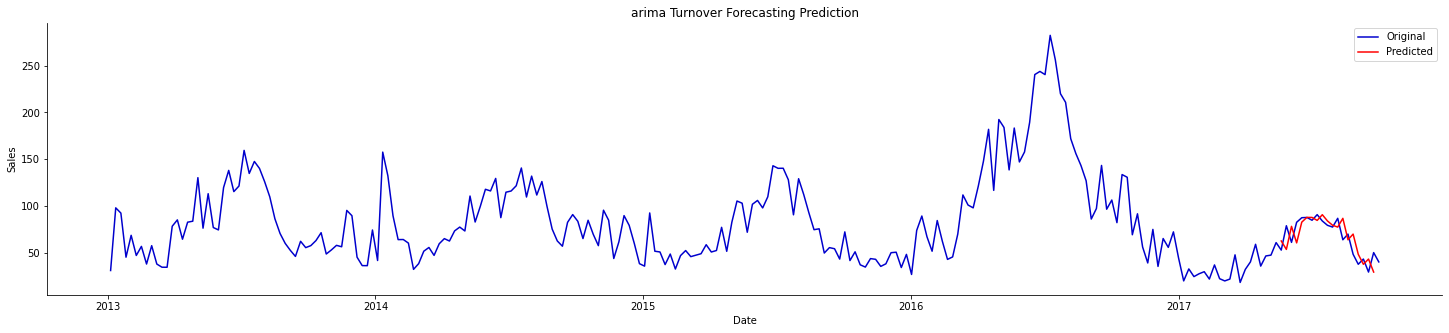

In [64]:
monitor_performance(df_with_forecast_diff, 20)